# Forecasting retail demand with Vertex AI and BigQuery ML

* adapted from github [tutorial](https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/workbench/demand_forecasting/forecasting-retail-demand.ipynb)
* optionally, run in [colab](https://colab.sandbox.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/workbench/demand_forecasting/forecasting-retail-demand.ipynb#scrollTo=J4CN-N_op94B)

### objectives and data

In this tutorial, you learn how to build ARIMA (Autoregressive integrated moving average) model from BigQuery ML on retail data

This tutorial uses the following Google Cloud ML services:
- BigQuery

The steps performed include:

* Explore data
* Model with BigQuery and the ARIMA model
* Evaluate the model
* Evaluate the model results using BigQuery ML (on training data)
* Evaluate the model results - MAE, MAPE, MSE, RMSE (on test data)
* Use the executor feature

**dataset** 
* This notebook uses the BigQuery public retail data set.
* The data covers 10 US stores and includes item level, department, product categories, and store details. 
* also includes explanatory variables such as price and gross margin

In [2]:
import os
# ! pip3 install --user --upgrade pandas-gbq 'google-cloud-bigquery[bqstorage,pandas]' scikit-learn

In [3]:
GCP_PROJECTS = !gcloud config get-value project
PROJECT_ID = GCP_PROJECTS[0]
PROJECT_NUM = !gcloud projects list --filter="$PROJECT_ID" --format="value(PROJECT_NUMBER)"
PROJECT_NUM = PROJECT_NUM[0]
REGION = 'us-central1'

print(f"PROJECT_ID: {PROJECT_ID}")
print(f"PROJECT_NUM: {PROJECT_NUM}")
print(f"REGION: {REGION}")

PROJECT_ID: hybrid-vertex
PROJECT_NUM: 934903580331
REGION: us-central1


### UUID

In [5]:
import random
import string

# Generate a uuid of a specifed length(default=8)
def generate_uuid(length: int = 8) -> str:
    return "".join(random.choices(string.ascii_lowercase + string.digits, k=length))

UUID = generate_uuid()
UUID

'3l8bz5ff'

### import packages

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

from google.cloud import bigquery
from google.cloud.bigquery import Client

from sklearn.metrics import (mean_absolute_error,
                             mean_absolute_percentage_error,
                             mean_squared_error)

%matplotlib inline

import warnings

warnings.filterwarnings("ignore")

## BigQuery dataset

In [7]:
# Set the name for the table
SALES_TABLE = "training_data_table"

# Construct a BigQuery client object.
client = Client(project=PROJECT_ID)

dataset_id = "demandforecasting" + "_" + UUID

print(f"dataset_id: {dataset_id}")

dataset_id: demandforecasting_3l8bz5ff


### create bigquery dataset

In [8]:
query = """
CREATE SCHEMA `{PROJECT_ID}.{dataset_id}`
OPTIONS(
  location="us"
  )
""".format(
    PROJECT_ID=PROJECT_ID, dataset_id=dataset_id
)
query_job = client.query(query)
print(query_job.result())

### EDA

In [9]:
query = """
SELECT * FROM `looker-private-demo.retail.transaction_detail`
"""
query_job = client.query(query)

In [10]:
query_job.to_dataframe()

,transaction_timestamp,transaction_id,store_id,channel_id,customer_id,line_items
0,2022-04-09 18:57:06+00:00,151619,1,2,<NA>,"[{'product_id': 21725, 'sale_price': 49.990001..."
1,2022-04-09 13:43:12+00:00,280553,1,1,18765,"[{'product_id': 25376, 'sale_price': 36.330001..."
2,2022-04-09 16:43:02+00:00,226013,1,2,<NA>,"[{'product_id': 18095, 'sale_price': 8.0, 'gro..."
3,2022-04-09 20:22:20+00:00,47449,1,1,<NA>,"[{'product_id': 22704, 'sale_price': 54.0, 'gr..."
4,2022-04-09 21:49:55+00:00,47407,1,1,50317,"[{'product_id': 109, 'sale_price': 12.98999977..."
...,...,...,...,...,...,...
297392,2018-11-15 17:34:25+00:00,73569,10,3,78000,"[{'product_id': 109, 'sale_price': 12.98999977..."
297393,2018-11-15 10:48:45+00:00,2650,10,1,<NA>,"[{'product_id': 28305, 'sale_price': 75.110000..."
297394,2018-11-15 20:01:54+00:00,109070,10,2,2148,"[{'product_id': 19158, 'sale_price': 89.989997..."
297395,2018-11-15 15:19:38+00:00,108983,10,2,1776,"[{'product_id': 3187, 'sale_price': 39.9799995..."


### create BQ view
* Create a view named important_fields using only the transaction_timestamp and line_items fields, where the store ID is 10.

In [11]:
query = """
CREATE OR REPLACE VIEW {dataset_id}.important_fields AS
(
    SELECT transaction_timestamp,line_items from `looker-private-demo.retail.transaction_detail` WHERE store_id = 10
)   
""".format(
    dataset_id=dataset_id
)
query_job = client.query(query)
print(query_job.result())

### inspect important fields

In [12]:
query = """
SELECT * FROM {dataset_id}.important_fields
""".format(
    dataset_id=dataset_id
)
query_job = client.query(query)

query_job.to_dataframe()

,transaction_timestamp,line_items
0,2019-02-19 18:25:28+00:00,"[{'product_id': 18057, 'sale_price': 119.94999..."
1,2019-02-19 14:23:42+00:00,"[{'product_id': 20552, 'sale_price': 64.0, 'gr..."
2,2019-08-23 08:44:35+00:00,"[{'product_id': 4507, 'sale_price': 163.639999..."
3,2019-08-23 22:20:34+00:00,"[{'product_id': 3446, 'sale_price': 11.0399999..."
4,2019-07-16 00:29:15+00:00,"[{'product_id': 3335, 'sale_price': 21.9500007..."
...,...,...
29682,2022-05-03 00:17:08+00:00,"[{'product_id': 23389, 'sale_price': 29.950000..."
29683,2020-09-10 19:11:47+00:00,"[{'product_id': 28316, 'sale_price': 29.950000..."
29684,2020-09-10 09:08:18+00:00,"[{'product_id': 28316, 'sale_price': 29.950000..."
29685,2019-07-12 17:49:58+00:00,"[{'product_id': 12728, 'sale_price': 29.950000..."


### Convert the transaction_timestamp field into a date.

In [13]:
query = """
CREATE OR REPLACE VIEW {dataset_id}.data_after_converting_timestamp_to_date AS
(
    SELECT EXTRACT(DATE FROM transaction_timestamp AT TIME ZONE "UTC") AS date,line_items from {dataset_id}.important_fields
)   
""".format(
    dataset_id=dataset_id
)
query_job = client.query(query)
print(query_job.result())

### check the date field values.

In [14]:
query = """
SELECT * FROM {dataset_id}.data_after_converting_timestamp_to_date
""".format(
    dataset_id=dataset_id
)
query_job = client.query(query)

query_job.to_dataframe()

,date,line_items
0,2018-08-19,"[{'product_id': 10498, 'sale_price': 39.990001..."
1,2018-08-19,"[{'product_id': 18049, 'sale_price': 30.090000..."
2,2018-08-19,"[{'product_id': 21687, 'sale_price': 65.0, 'gr..."
3,2018-08-19,"[{'product_id': 21708, 'sale_price': 70.0, 'gr..."
4,2019-11-27,"[{'product_id': 27419, 'sale_price': 39.0, 'gr..."
...,...,...
29682,2021-05-05,"[{'product_id': 28302, 'sale_price': 6.0700001..."
29683,2022-08-27,"[{'product_id': 28302, 'sale_price': 6.0700001..."
29684,2021-05-22,"[{'product_id': 28302, 'sale_price': 6.0700001..."
29685,2021-10-30,"[{'product_id': 28302, 'sale_price': 6.0700001..."


### load to dataframe

In [15]:
df_intermediary = query_job.to_dataframe()

In [16]:
df_intermediary.dtypes

date          dbdate
line_items    object
dtype: object

## data prep
* The `line_items` field is an array of structs. 
* Split the array into its component parts, product_id, sale_price, and gross_margin.

In [17]:
query = """
CREATE OR REPLACE VIEW {dataset_id}.split_array_of_structs AS
 
(SELECT date,line_items
FROM {dataset_id}.data_after_converting_timestamp_to_date, UNNEST(line_items) AS line_items)
""".format(
    dataset_id=dataset_id
)
query_job = client.query(query)
print(query_job.result())

In [18]:
query = """
SELECT * FROM {dataset_id}.split_array_of_structs
""".format(
    dataset_id=dataset_id
)
query_job = client.query(query)

query_job.to_dataframe()

,date,line_items
0,2020-07-19,"{'product_id': 22705, 'sale_price': 25.0, 'gro..."
1,2020-07-19,"{'product_id': 3211, 'sale_price': 14.86999988..."
2,2020-07-19,"{'product_id': 8263, 'sale_price': 60.0, 'gros..."
3,2020-07-19,"{'product_id': 20552, 'sale_price': 64.0, 'gro..."
4,2020-07-19,"{'product_id': 20552, 'sale_price': 64.0, 'gro..."
...,...,...
30736,2022-09-12,"{'product_id': 24490, 'sale_price': 22.0, 'gro..."
30737,2022-09-12,"{'product_id': 19960, 'sale_price': 99.9899978..."
30738,2022-09-12,"{'product_id': 24097, 'sale_price': 67.8099975..."
30739,2022-09-12,"{'product_id': 21837, 'sale_price': 44.9900016..."


#### Remove the extra columns to keep only date and product_id.

In [19]:
query = """
CREATE OR REPLACE VIEW {dataset_id}.splitting_struct_columns AS
 
(SELECT date,line_items.product_id as product_id
FROM {dataset_id}.split_array_of_structs)
""".format(
    dataset_id=dataset_id
)
query_job = client.query(query)
print(query_job.result())

In [20]:
query = """
SELECT * FROM {dataset_id}.splitting_struct_columns 
""".format(
    dataset_id=dataset_id
)
query_job = client.query(query)

query_job.to_dataframe()

,date,product_id
0,2023-01-31,124
1,2023-01-31,2487
2,2023-01-31,17082
3,2023-01-31,26485
4,2023-01-31,3488
...,...,...
30736,2018-12-15,20547
30737,2018-12-15,19010
30738,2018-12-15,3295
30739,2018-12-15,2457


### Count the sales of a product for each date.

In [21]:
query = """
CREATE OR REPLACE VIEW {dataset_id}.sales_count_per_date AS
 
(SELECT date,product_id,COUNT(*) as sales_count
FROM {dataset_id}.splitting_struct_columns GROUP BY date,product_id)
""".format(
    dataset_id=dataset_id
)
query_job = client.query(query)
print(query_job.result())

In [22]:
query = """
SELECT * FROM {dataset_id}.sales_count_per_date
""".format(
    dataset_id=dataset_id
)
query_job = client.query(query)

query_job.to_dataframe()

,date,product_id,sales_count
0,2022-12-30,16109,1
1,2020-10-17,16097,1
2,2019-10-19,28906,1
3,2023-02-09,4270,1
4,2021-03-19,22699,1
...,...,...,...
29601,2022-11-05,5793,1
29602,2021-05-14,22848,1
29603,2020-10-12,21654,1
29604,2022-07-01,1529,1


#### Create a view for the five products that have sold the most units over the entire date range.

In [23]:
query = """
CREATE OR REPLACE VIEW {dataset_id}.top_five_products AS (
    WITH topsellingitems AS(
         SELECT 
            product_id,
            sum(sales_count) sum_sales
        FROM
            `{dataset_id}.sales_count_per_date` 
        GROUP BY 
            product_id
        ORDER BY sum_sales DESC
        LIMIT 5 #Top N
    )
    SELECT 
        date,
        product_id,
        sales_count
    FROM
        `{dataset_id}.sales_count_per_date` 
    WHERE
        product_id IN (SELECT product_id FROM topsellingitems)
    )
""".format(
    dataset_id=dataset_id
)
query_job = client.query(query)
print(query_job.result())

In [24]:
query = """
SELECT * FROM {dataset_id}.top_five_products
""".format(
    dataset_id=dataset_id
)
query_job = client.query(query)

query_job.to_dataframe()

,date,product_id,sales_count
0,2020-11-23,20552,1
1,2019-12-30,20552,1
2,2021-12-08,20552,2
3,2019-08-27,20547,2
4,2020-09-16,20552,2
...,...,...,...
2441,2021-09-13,13596,1
2442,2022-06-06,23641,1
2443,2022-06-06,20547,1
2444,2021-01-21,20552,1


### load to dataframe

In [25]:
df = query_job.to_dataframe()
print(df)

            date  product_id  sales_count
0     2020-11-23       20552            1
1     2019-12-30       20552            1
2     2021-12-08       20552            2
3     2019-08-27       20547            2
4     2020-09-16       20552            2
...          ...         ...          ...
2441  2021-09-13       13596            1
2442  2022-06-06       23641            1
2443  2022-06-06       20547            1
2444  2021-01-21       20552            1
2445  2023-02-13       20552            2

[2446 rows x 3 columns]


In [26]:
df.dtypes

date           dbdate
product_id      Int64
sales_count     Int64
dtype: object

In [27]:
# Convert the date field's data type to datetime.
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")

## gap filling 

* For this forecasting model, date values need to be present for all dates, for each product.
* To construct a dataframe with 0 values for the sales_count field, on dates in which products were not sold, determine the minimum and maximum dates so that you know which dates need 0 values.

In [28]:
# get earliest date

query = """
SELECT MIN(DATE) AS min_date FROM {dataset_id}.top_five_products
""".format(
    dataset_id=dataset_id
)
query_job = client.query(query)

query_job.to_dataframe()

,min_date
0,2018-06-02


In [29]:
# get latest date

query = """
SELECT MAX(DATE) FROM {dataset_id}.top_five_products
""".format(
    dataset_id=dataset_id
)
query_job = client.query(query)

query_job.to_dataframe()

,f0_
0,2023-03-22


In [30]:
# add full date range to df
dates = pd.date_range(start="2016-12-17", end="2021-10-06").to_frame()

In [31]:
dates.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1755 entries, 2016-12-17 to 2021-10-06
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   0       1755 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 27.4 KB


In [32]:
df.loc[df["product_id"] == 20552].sort_values(by=["date"])

,date,product_id,sales_count
1672,2018-07-02,20552,1
112,2018-07-05,20552,1
57,2018-07-26,20552,1
1651,2018-08-19,20552,1
267,2018-08-23,20552,1
...,...,...,...
874,2023-03-17,20552,1
996,2023-03-18,20552,2
306,2023-03-20,20552,1
1264,2023-03-21,20552,1


### To make a dataframe in which each product has zero missing dates, merge each of the five products' data with the dates dataframe.

* Start with `product_id=20552`

In [33]:
df1 = (
    pd.merge(
        df.loc[df["product_id"] == 20552],
        dates,
        left_on="date",
        right_on=0,
        how="outer",
    )
    .sort_values(by=["date"])
    .drop(columns=0)
)  # merging dates dataframe with product_id matching rows
df1["product_id"] = 20552  # product_id will be null so making it the specified values
df1.reset_index(inplace=True, drop=True)  # making index to start from 0
df1 = df1.fillna(0)  # for sales_count making null values as 0
df1["sales_count"] = df1["sales_count"].astype(
    "int"
)  # convert sales_count column to integer
print("data after converting for a product with product_id 20552")
print(df1)

df2 = (
    pd.merge(
        df.loc[df["product_id"] == 13596],
        dates,
        left_on="date",
        right_on=0,
        how="outer",
    )
    .sort_values(by=["date"])
    .drop(columns=0)
)  # merging dates dataframe with product_id matching rows
df2["product_id"] = 13596  # product_id will be null so making it the specified values
df2.reset_index(inplace=True, drop=True)  # making index to start from 0
df2 = df2.fillna(0)  # for sales_count making null values as 0
df2["sales_count"] = df2["sales_count"].astype(
    "int"
)  # convert sales_count column to integer
print(df2)

df3 = (
    pd.merge(
        df.loc[df["product_id"] == 23641],
        dates,
        left_on="date",
        right_on=0,
        how="outer",
    )
    .sort_values(by=["date"])
    .drop(columns=0)
)  # merging dates dataframe with product_id matching rows
df3["product_id"] = 23641  # product_id will be null so making it the specified values
df3.reset_index(inplace=True, drop=True)  # making index to start from 0
df3 = df3.fillna(0)  # for sales_count making null values as 0
df3["sales_count"] = df3["sales_count"].astype(
    "int"
)  # convert sales_count column to integer
print(df3)

df4 = (
    pd.merge(
        df.loc[df["product_id"] == 28305],
        dates,
        left_on="date",
        right_on=0,
        how="outer",
    )
    .sort_values(by=["date"])
    .drop(columns=0)
)  # merging dates dataframe with product_id matching rows
df4["product_id"] = 28305  # product_id will be null so making it the specified values
df4.reset_index(inplace=True, drop=True)  # making index to start from 0
df4 = df4.fillna(0)  # for sales_count making null values as 0
df4["sales_count"] = df4["sales_count"].astype(
    "int"
)  # convert sales_count column to integer
print(df4)

df5 = (
    pd.merge(
        df.loc[df["product_id"] == 20547],
        dates,
        left_on="date",
        right_on=0,
        how="outer",
    )
    .sort_values(by=["date"])
    .drop(columns=0)
)  # merging dates dataframe with product_id matching rows
df5["product_id"] = 20547  # product_id will be null so making it the specified values
df5.reset_index(inplace=True, drop=True)  # making index to start from 0
df5 = df5.fillna(0)  # for sales_count making null values as 0
df5["sales_count"] = df5["sales_count"].astype(
    "int"
)  # convert sales_count column to integer
print(df5)

data after converting for a product with product_id 20552
           date  product_id  sales_count
0    2016-12-17       20552            0
1    2016-12-18       20552            0
2    2016-12-19       20552            0
3    2016-12-20       20552            0
4    2016-12-21       20552            0
...         ...         ...          ...
2078 2023-03-17       20552            1
2079 2023-03-18       20552            2
2080 2023-03-20       20552            1
2081 2023-03-21       20552            1
2082 2023-03-22       20552            2

[2083 rows x 3 columns]
           date  product_id  sales_count
0    2016-12-17       13596            0
1    2016-12-18       13596            0
2    2016-12-19       13596            0
3    2016-12-20       13596            0
4    2016-12-21       13596            0
...         ...         ...          ...
1978 2023-03-15       13596            2
1979 2023-03-16       13596            1
1980 2023-03-17       13596            1
1981 2023-03-19

In [34]:
# merge all five dataframes into one new dataframe

pdList = [df1, df2, df3, df4, df5]  # List of your dataframes
new_df = pd.concat(pdList)
new_df

,date,product_id,sales_count
0,2016-12-17,20552,0
1,2016-12-18,20552,0
2,2016-12-19,20552,0
3,2016-12-20,20552,0
4,2016-12-21,20552,0
...,...,...,...
1953,2023-03-11,20547,1
1954,2023-03-15,20547,2
1955,2023-03-17,20547,1
1956,2023-03-21,20547,3


In [35]:
# reset index

new_df.reset_index(inplace=True, drop=True)
print(new_df)

           date  product_id  sales_count
0    2016-12-17       20552            0
1    2016-12-18       20552            0
2    2016-12-19       20552            0
3    2016-12-20       20552            0
4    2016-12-21       20552            0
...         ...         ...          ...
9947 2023-03-11       20547            1
9948 2023-03-15       20547            2
9949 2023-03-17       20547            1
9950 2023-03-21       20547            3
9951 2023-03-22       20547            2

[9952 rows x 3 columns]


### inspect top 5

In [36]:
query = """
SELECT DISTINCT product_id from {dataset_id}.top_five_products
""".format(
    dataset_id=dataset_id
)
query_job = client.query(query)

In [37]:
query_job.to_dataframe()

,product_id
0,23641
1,13596
2,20547
3,20552
4,28305


## plot `sales_count` over time, for each product

**TODO**
* fix these plots

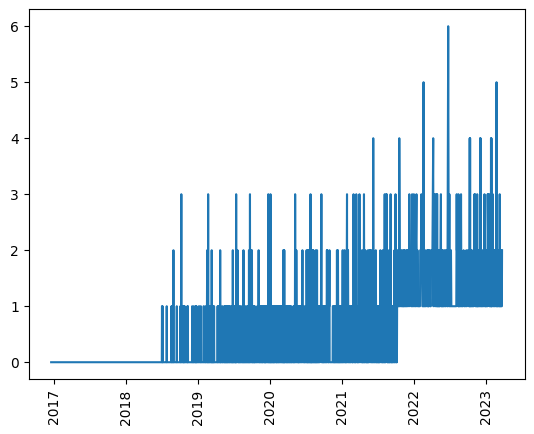

In [41]:
plt.plot(
    new_df.loc[new_df["product_id"] == 20552]["date"],
    new_df.loc[new_df["product_id"] == 20552]["sales_count"],
)
plt.xticks(rotation="vertical");

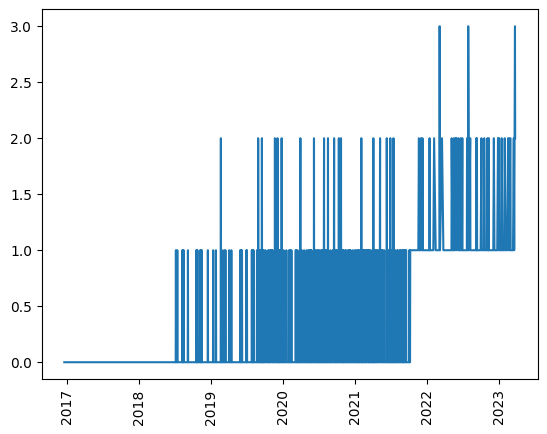

In [42]:
plt.plot(
    new_df.loc[new_df["product_id"] == 20547]["date"],
    new_df.loc[new_df["product_id"] == 20547]["sales_count"],
)
plt.xticks(rotation="vertical");

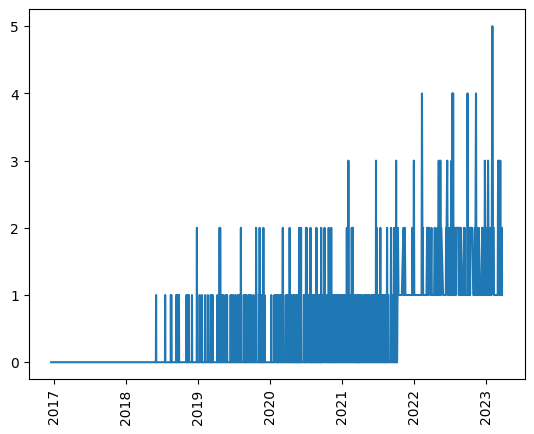

In [43]:
plt.plot(
    new_df.loc[new_df["product_id"] == 28305]["date"],
    new_df.loc[new_df["product_id"] == 28305]["sales_count"],
)
plt.xticks(rotation="vertical");

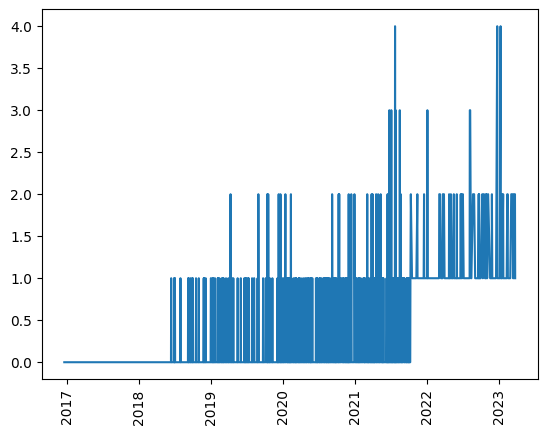

In [44]:
plt.plot(
    new_df.loc[new_df["product_id"] == 23641]["date"],
    new_df.loc[new_df["product_id"] == 23641]["sales_count"],
)
plt.xticks(rotation="vertical");

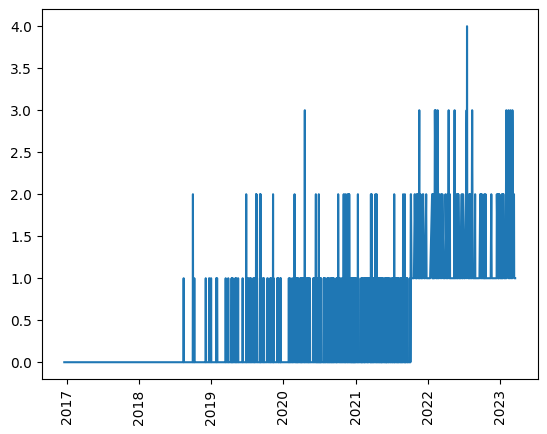

In [45]:
plt.plot(
    new_df.loc[new_df["product_id"] == 13596]["date"],
    new_df.loc[new_df["product_id"] == 13596]["sales_count"],
)
plt.xticks(rotation="vertical");

In [46]:
new_df.dtypes

date           datetime64[ns]
product_id              int64
sales_count             int64
dtype: object

## Create new BigQuery table from new `df`

In [47]:
job_config = bigquery.LoadJobConfig(
    # Specify a (partial) schema. All columns are always written to the
    # table. The schema is used to assist in data type definitions.
    schema=[
        bigquery.SchemaField("product_id", bigquery.enums.SqlTypeNames.INTEGER),
        bigquery.SchemaField("date", bigquery.enums.SqlTypeNames.DATE),
        bigquery.SchemaField("sales_count", bigquery.enums.SqlTypeNames.INTEGER),
    ],
    # Optionally, set the write disposition. BigQuery appends loaded rows
    # to an existing table by default, but with WRITE_TRUNCATE write
    # disposition it replaces the table with the loaded data.
    write_disposition="WRITE_TRUNCATE",
)

# save the dataframe to a table in the created dataset
job = client.load_table_from_dataframe(
    new_df,
    "{}.{}.{}".format(PROJECT_ID, dataset_id, SALES_TABLE),
    job_config=job_config,
)  # Make an API request.
job.result()  # Wait for the job to complete.

LoadJob<project=hybrid-vertex, location=US, id=adc5e153-e004-4c20-aae1-1428b7c8a275>

### Create a training dataset by setting a date range that limits the data being used.

In [48]:
# select the date-range and item-id(top 5) for training-data and create a table for the same
TRAININGDATA_STARTDATE = "2016-12-17"
TRAININGDATA_ENDDATE = "2021-6-01"
query = """
CREATE OR REPLACE TABLE {PROJECT_ID}.{DATASET}.training_data AS (
    SELECT
        *
    FROM
        `{DATASET}.{SALES_TABLE}`
    WHERE
        date BETWEEN '{STARTDATE}' AND '{ENDDATE}'
        );
""".format(
    STARTDATE=TRAININGDATA_STARTDATE,
    ENDDATE=TRAININGDATA_ENDDATE,
    DATASET=dataset_id,
    SALES_TABLE=SALES_TABLE,
    PROJECT_ID=PROJECT_ID,
)
# execute the query (as it is a create query, there won't be any tabular output)
query_job = client.query(query)
print(query_job.result())

In [49]:
# Select the original data for plotting

df_historical = new_df[
    (new_df["date"] >= pd.to_datetime(TRAININGDATA_STARTDATE))
    & (new_df["date"] <= pd.to_datetime(TRAININGDATA_ENDDATE))
].copy()
df_historical

,date,product_id,sales_count
0,2016-12-17,20552,0
1,2016-12-18,20552,0
2,2016-12-19,20552,0
3,2016-12-20,20552,0
4,2016-12-21,20552,0
...,...,...,...
9617,2021-05-28,20547,0
9618,2021-05-29,20547,0
9619,2021-05-30,20547,0
9620,2021-05-31,20547,0


# Modeling with BQ ARIMA+

* train ARIMA model with prepared dataset

In [50]:
# Train an ARIMA model on the created dataset
query = """
CREATE OR REPLACE MODEL `{PROJECT_ID}.{DATASET}.arima_model`

OPTIONS(
  MODEL_TYPE='ARIMA',
  TIME_SERIES_TIMESTAMP_COL='date',
  TIME_SERIES_DATA_COL='sales_count',
  TIME_SERIES_ID_COL='product_id') AS

SELECT
    date,
    product_id,
    sales_count
FROM
  `{DATASET}.training_data`
""".format(
    PROJECT_ID=PROJECT_ID, DATASET=dataset_id
)
# execute the query
job = client.query(query)
job.result()

# Evaluate the model

* To evaluate the trained model, get forecasts for the 90 days after the last date of the training data
* In BigQuery ML, provide the number of forecast days using the `HORIZON` argument
* Specify the confidence interval for the forecast using the `CONFIDENCE_LEVEL` argument

In [51]:
query = '''DECLARE HORIZON STRING DEFAULT "90"; #number of values to forecast
DECLARE CONFIDENCE_LEVEL STRING DEFAULT "0.90"; ## required confidence level

EXECUTE IMMEDIATE format("""
    SELECT
      *
    FROM
      ML.FORECAST(MODEL {dataset_id}.arima_model,
                  STRUCT(%s AS horizon,
                         %s AS confidence_level)
                 )
    """,HORIZON,CONFIDENCE_LEVEL)'''.format(
    dataset_id=dataset_id
)
job = client.query(query)
dfforecast = job.to_dataframe()

In [52]:
dfforecast.head()

,product_id,forecast_timestamp,forecast_value,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,confidence_interval_lower_bound,confidence_interval_upper_bound
0,13596,2021-06-02 00:00:00+00:00,0.082150,0.000027,0.9,0.082106,0.082194,0.082106,0.082194
1,13596,2021-06-03 00:00:00+00:00,0.013890,0.000039,0.9,0.013826,0.013954,0.013826,0.013954
2,13596,2021-06-04 00:00:00+00:00,0.198933,0.000051,0.9,0.198850,0.199017,0.198850,0.199017
3,13596,2021-06-05 00:00:00+00:00,0.217974,0.000051,0.9,0.217890,0.218059,0.217890,0.218059
4,13596,2021-06-06 00:00:00+00:00,0.134313,0.000051,0.9,0.134229,0.134398,0.134229,0.134398


In [53]:
print(f"Number of rows: {dfforecast.shape[0]}")

Number of rows: 450


### Clean the historical and forecasted values for plotting.

In [54]:
df_historical.sort_values(by=["product_id", "date"], inplace=True)
dfforecast.sort_values(by=["product_id", "forecast_timestamp"], inplace=True)

# Select the actual data to plot against the forecasted data
day_diff = (new_df["date"] - pd.to_datetime(TRAININGDATA_ENDDATE)).dt.days
df_actual_90d = new_df[new_df["product_id"].isin(dfforecast["product_id"].unique())][
    (day_diff > 0) & (day_diff <= 90)
].copy()
df_actual_90d.shape

(450, 3)

### plot historical and forecasted values

Product_id :  13596


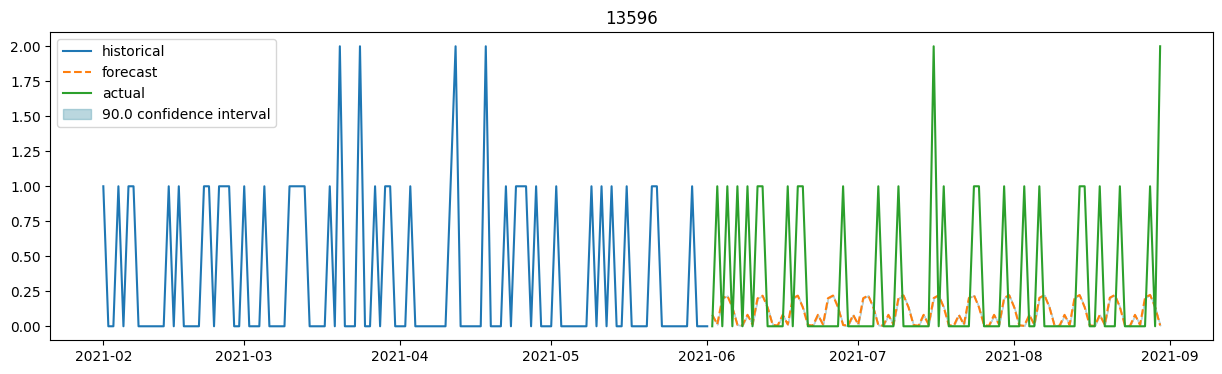

Product_id :  20547


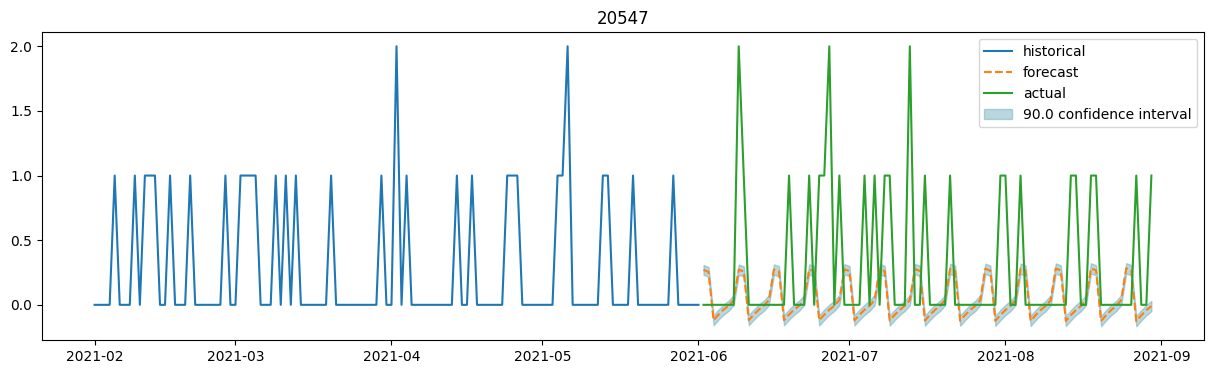

Product_id :  20552


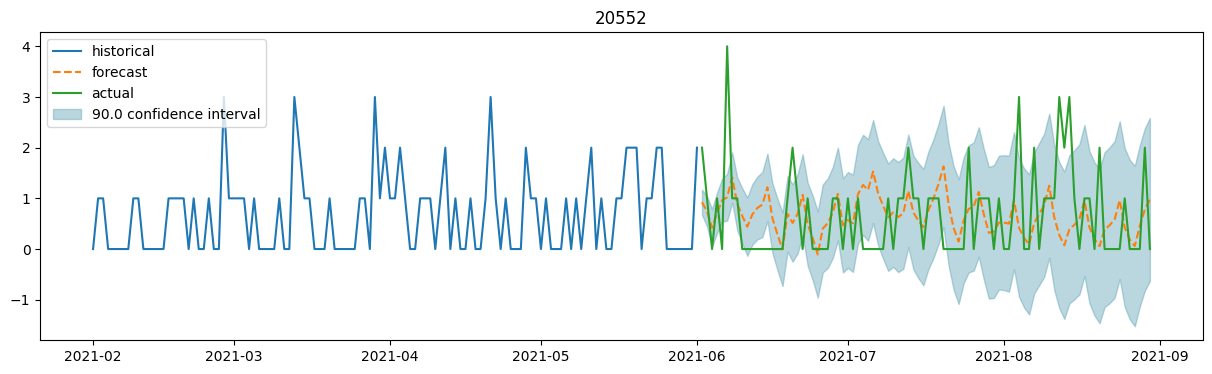

Product_id :  23641


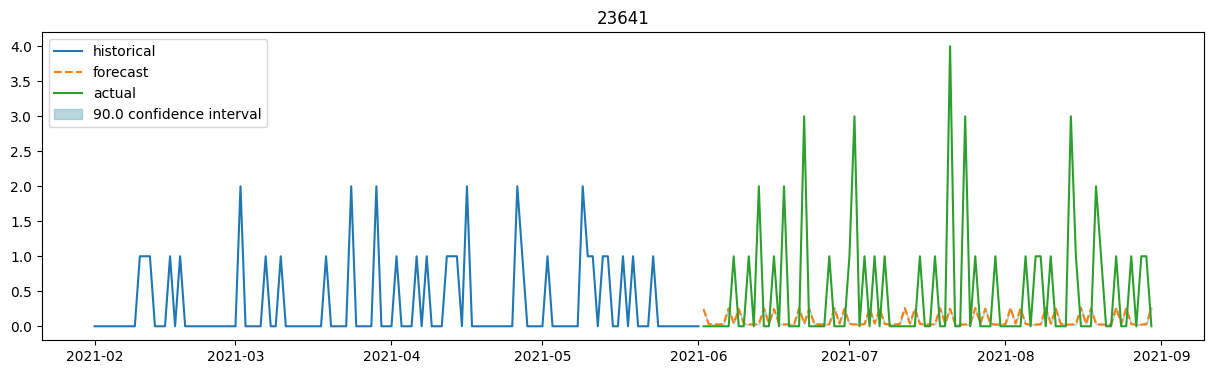

Product_id :  28305


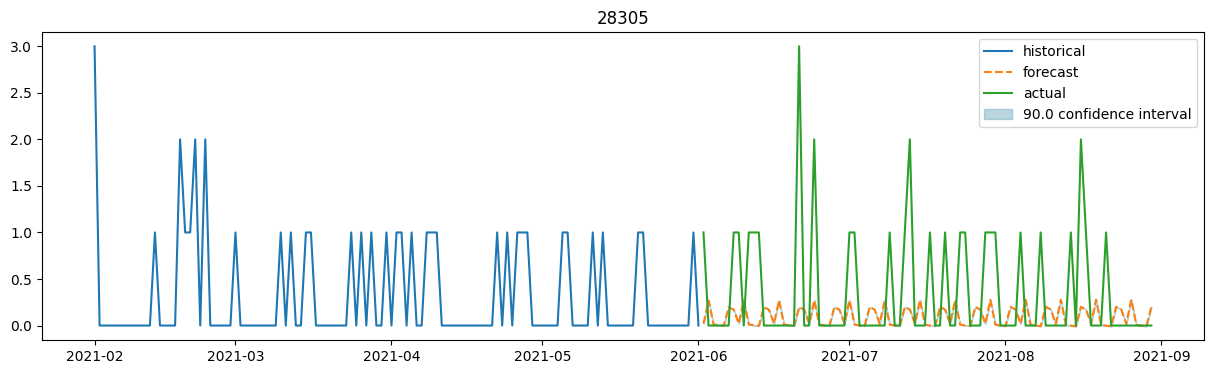

In [55]:
def plot_hist_forecast(
    historical, forecast, actual, hist_start="", hist_end="", title=""
):
    if hist_start != "":
        historical = historical[
            historical["date"] >= pd.to_datetime(hist_start, format="%Y-%m-%d")
        ].copy()
    if hist_end != "":
        historical = historical[
            historical["date"] <= pd.to_datetime(hist_end, format="%Y-%m-%d")
        ].copy()

    plt.figure(figsize=(15, 4))
    plt.plot(historical["date"], historical["sales_count"], label="historical")
    # Plot the forecast data
    plt.plot(
        forecast["forecast_timestamp"],
        forecast["forecast_value"],
        label="forecast",
        linestyle="--",
    )
    # Plot the actual data
    plt.plot(actual["date"], actual["sales_count"], label="actual")
    # plot the confidence interval
    confidence_level = forecast["confidence_level"].iloc[0] * 100
    low_CI = forecast["confidence_interval_lower_bound"]
    upper_CI = forecast["confidence_interval_upper_bound"]

    # Shade the confidence interval
    plt.fill_between(
        forecast["forecast_timestamp"],
        low_CI,
        upper_CI,
        color="#539caf",
        alpha=0.4,
        label=f"{confidence_level} confidence interval",
    )
    plt.legend()
    plt.title(title)
    plt.show()
    return


product_id_list = dfforecast["product_id"].unique()
for i in product_id_list:
    print("Product_id : ", i)
    plot_hist_forecast(
        df_historical[df_historical["product_id"] == i],
        dfforecast[dfforecast["product_id"] == i],
        df_actual_90d[df_actual_90d["product_id"] == i],
        hist_start="2021-02-01",
        title=i,
    )

While most of the predictions look decent, you can also see that the actual ranges fall into the 90% confidence interval suggested by the model. 

* Under the hood, BigQuery ML performs many computationally expensive tasks even considering the seasonal and holiday information.

* The coefficients learned by BigQuery ML's ARIMA model can also be checked by querying for <a href="https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-arima-coefficients">ARIMA_COEFFICIENTS</a> from the model.

In [56]:
query = """
SELECT
  *
FROM 
  ML.ARIMA_COEFFICIENTS(MODEL {dataset_id}.arima_model)
""".format(
    dataset_id=dataset_id
)
query_job = client.query(query)

In [57]:
query_job.to_dataframe()

,product_id,ar_coefficients,ma_coefficients,intercept_or_drift
0,13596,"[1.3997716843142813, -1.16831338278741, 0.6626...",[],0.093530
1,20547,[0.6932273638017995],"[-0.9194217641563278, 0.03605586701567885, -0....",0.048456
2,20552,"[-0.37689002494495805, -0.6650864364839284]","[0.031768120678020643, 0.7589626997463903, -0....",0.000000
3,23641,"[-0.19020382909251285, 0.8581904718294262, 0.3...",[],0.096897
4,28305,"[-0.8879458136630748, -0.6948513209436006]","[0.8599529161476914, 0.8438654943556937, 0.228...",0.094988


* `product_id` column represents the index column that we've specified while training the ARIMA model.
* `ar_coefficients` column corresponds to the autoregressive coefficients in the ARIMA algorithm (non-seasonal p).
* `ma_coefficients` refers to the moving average coefficients in the ARIMA algorithm (non-seasonal q).
* `intercept_or_drift` is the constant term in the ARIMA algorithm.

## Evaluating the model results with BigQuery ML 

BigQuery ML also provides the `ML.EVALUATE` function for checking the evaluation metrics of the trained model. 

For the ARIMA model, you can see the model being evaluated on `log_likelihood`, `AIC` and `variance`. 

In [58]:
query = """
SELECT
  *
FROM
  ML.EVALUATE(MODEL {dataset_id}.arima_model)
""".format(
    dataset_id=dataset_id
)
query_job = client.query(query)

query_job.to_dataframe()

,product_id,non_seasonal_p,non_seasonal_d,non_seasonal_q,has_drift,log_likelihood,AIC,variance,seasonal_periods
0,13596,5,0,0,False,14466.699873,-28919.399746,7.332616e-10,[WEEKLY]
1,20547,1,0,4,False,3833.671082,-7653.342163,5.270612e-04,[WEEKLY]
2,20552,2,1,3,False,762.305463,-1512.610926,2.290834e-02,"[WEEKLY, YEARLY]"
3,23641,5,0,0,False,10750.208364,-21486.416729,1.537700e-08,[WEEKLY]
4,28305,2,0,3,False,11691.481703,-23368.963405,2.352344e-09,[WEEKLY]


## calculate custom metrics on test set

> MAE, MAPE, MSE, RMSE

Generally, to evaluate the forecast model, you can choose metrics depending on how you want to evaluate. For starters, you can choose from the following: 
* Mean Absolute Error (MAE): Average of the absolute differences between the actual values and the forecasted values.
* Mean Absolute Percentage Error (MAPE): Average of the percentages of absolute difference between the actual and forecasted values to the actual values.
* Mean Squared Error (MSE): Average of squared differences between the actual and forecasted values.
* Root Mean Squared Error (RMSE): Root of MSE

In [59]:
df_actual_90d.sort_values(by=["product_id", "date"], inplace=True)
df_actual_90d.reset_index(drop=True, inplace=True)
dfforecast.sort_values(by=["product_id", "forecast_timestamp"], inplace=True)
dfforecast.reset_index(drop=True, inplace=True)

In [60]:
errors = {"product_id": [], "MAE": [], "MAPE": [], "MSE": [], "RMSE": []}
for i in product_id_list:
    mae = mean_absolute_error(
        df_actual_90d[df_actual_90d["product_id"] == i]["sales_count"],
        dfforecast[dfforecast["product_id"] == i]["forecast_value"],
    )
    mape = mean_absolute_percentage_error(
        df_actual_90d[df_actual_90d["product_id"] == i]["sales_count"],
        dfforecast[dfforecast["product_id"] == i]["forecast_value"],
    )

    mse = mean_squared_error(
        df_actual_90d[df_actual_90d["product_id"] == i]["sales_count"],
        dfforecast[dfforecast["product_id"] == i]["forecast_value"],
        squared=True,
    )

    rmse = mean_squared_error(
        df_actual_90d[df_actual_90d["product_id"] == i]["sales_count"],
        dfforecast[dfforecast["product_id"] == i]["forecast_value"],
        squared=False,
    )

    errors["product_id"].append(i)
    errors["MAE"].append(mae)
    errors["MAPE"].append(mape)
    errors["MSE"].append(mse)
    errors["RMSE"].append(rmse)
errors = pd.DataFrame(errors)
errors

,product_id,MAE,MAPE,MSE,RMSE
0,13596,0.323904,2.697096e+14,0.284451,0.533339
1,20547,0.367775,3.710691e+14,0.355881,0.596558
2,20552,0.673081,1.453245e+15,0.832664,0.912504
3,23641,0.544210,3.411625e+14,0.910183,0.954035
4,28305,0.391219,3.222693e+14,0.425698,0.652456


From the values obtained for these error measures, it looks like product ID 20552's 13,596's error measures are high. 

> Note that these error measures are an aggregate of all the individual forecasts made during the test period and so reflect an overall picture of the model's performance over the selected period. 

Ideally, the lower these error measures, the better the model is at forecasting.

# cleaning up

In [ ]:
# # Set dataset variable to the ID of the dataset to fetch.
# dataset = f"{PROJECT_ID}.{dataset_id}"

# # Use the delete_contents parameter to delete a dataset and its contents.
# # Use the not_found_ok parameter to not receive an error if the dataset has already been deleted.
# client.delete_dataset(
#     dataset_id, delete_contents=True, not_found_ok=True
# )  # Make an API request.

# print("Deleted dataset '{}'.".format(dataset_id))